In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pandas as pd
import polars as pl
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import random

from src.theory_sims import *
from src.figures import plot_prior_ppd
from scipy import stats
import os
from tqdm.notebook import tqdm
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

%autosave 20

fit_ensemble = False


#Set seed
random.seed(42)
print('Creating output directories')
for directory in ["./output/", "./output/figures/", "./output/tables", "output/results", "output/generated", "output/tables"]:
    if not os.path.exists(directory):
        os.makedirs(directory)

Autosaving every 20 seconds
Creating output directories


# Evaluating the evidence for False Positives 

### Load data

In [2]:
#We're going to use pandas to get the sheets coresponding to close replications 
xl = pd.ExcelFile("dat/LindenHeterogeneity.xlsx")
sheets = xl.sheet_names
sheets
def get_close_rep(name):
    strings_to_contain = ["ML1", "ML2", "ML3", "ML4", "RRR"]
    if any([string in name for string in strings_to_contain]):
        return True
close_rep_sheets = [sheet for sheet in sheets if get_close_rep(sheet)]

print(close_rep_sheets)
pl.read_excel("dat/LindenHeterogeneity.xlsx", sheet_name=close_rep_sheets[0])

dfs = []
for sheet in close_rep_sheets:
    temp = pl.read_excel("dat/LindenHeterogeneity.xlsx", sheet_name=sheet).with_columns(
        (pl.lit(sheet)).alias("sheet")
    )
    if sheet == "ML1 quotes":
        temp = temp.rename({" d_obs": "d_obs"})
    #Remove original study for RRR
    if 'RRR' in sheet:
        temp = temp.slice(1, temp.height) #Remove original effect size
    if 'ML1' in sheet:
        pass #original effect sizes do not appear to be included
    if 'ML3' in sheet:
        pass #Only replications included in dataset
    if 'ML2' in sheet:
        pass #Only replications included in dataset

    temp = temp.with_columns(
        ( pl.col("d_obs")/np.sqrt(4/pl.col("N")) ).alias("z")
        ).with_columns(
    (np.abs(pl.col("z")) > norm.ppf(0.975)).alias("sig").cast(pl.Boolean)
    )
    dfs.append(temp)
heterogeneity_sheet = pl.concat(dfs)

['ML1 allowed forbidden', 'ML1 anchor NYC', 'ML1 anchor chicago', 'ML1 anchor everest', 'ML1 anchor babies', 'ML1 currency prime', 'ML1 flag prime', 'ML1 gain loss', 'ML1 gamblers', 'ML1 imagine contact', 'ML1 category scales', 'ML1 quotes', 'ML1 reciprocity', 'ML1 I and E math', 'ML1 sex diff math', 'ML1 sunk costs', 'ML3 avail heuristics', 'ML3 cred prej int', 'ML3 cred prej main', 'ML3 elaboration int', 'ML3 elaboration main', 'ML3 metaphor', 'ML3 persistence', 'ML3 power persp', 'ML3 self esteem int', 'ML3 self esteem main', 'ML3 stroop', 'ML3 warmth', 'ML3 weight', 'RRR3 gram crim', 'RRR3 gram process', 'RRR3 gram intent', 'RRR4 deplete variable', 'RRR4 deplete RT', 'RRR5 commit subjective', 'RRR5 commit exit', 'RRR5 commit neglect', 'RRR5 commit voice', 'RRR5 commit loyalty', 'RRR6 facial feedback', 'ML2 1 Huang', 'ML2 2 Kay', 'ML2 3 Alter', 'ML2 6 Bauer', 'ML2 9 Critcher', 'ML2 12 Anderson', 'ML2 13 Ross', 'ML2 14 Ross2', 'ML2 15 Giessner', 'ML2 18 Risen', 'ML2 20 Norenzayan', '

### Frequentist Approach
If a given hypothesis is null, it should replicate 5\% of the time. We assume that each of the labs conducts the replication independently, such that the rate of replication should be characterized by a binomial distribution: 

\begin{align*}
k&=\text{Binomial}(n, .05)
\end{align*}

Here, $k$ is the number of significant results and $n$ the number of total number of replications for a given hypothesis. To estimate the probability that a given multi-lab replication's outcomes are consistent with the null hypothesis, we can use a binomial, two-tailed p-value. Here, $X$ represents every possible number of significant studies, ranging from $0$ to $n$. To calculate the associated \textit{p}-value, we can calculate the sum of all values for $X$ which are less probable than the observed value, $k$. We define a set of such values, $S$ such that $S=\{i\colon \text{Pr}(X=i)\leq \text{Pr} (X=k)\}$

\begin{align*}
p &= \sum_{i \in S} \binom{n}{i} \alpha^{i} (1-\alpha)^{n-i}
\end{align*}

We note that we are not relying on the \textit{p}-value here to explicitly test whether we can reject a null hypothesis that a given hypothesis is truly null, but instead we are evaluating the \textit{p}-values as the probability of observing the data, given the null model implied by the definition of a false positive. 

In [4]:

def calculate_p_value(row):
    return stats.binomtest(k=row[2], n=row[1],p=.05).pvalue

#Aggregate by hypothesis
agg_df = heterogeneity_sheet.group_by('sheet').agg(
        pl.len().alias('N'),
        pl.sum('sig').alias('K'),
        pl.mean('sig').alias('prob')
)


#Join with data indicating meta-analytic significance
linden_data = pl.read_csv("dat/LindenSigRep.csv")
agg_df = agg_df.join(linden_data, on='sheet')
agg_df = agg_df.with_columns((agg_df.map_rows(calculate_p_value)['map'].alias('p')))
agg_df = agg_df.sort(by="p",descending=True)



In [8]:
agg_df['N'].median()

36.0

In [9]:
print('Total failed reps')
print(agg_df.filter(pl.col('Sig')==0).shape[0])
print('Total inconsistent')
print((agg_df.filter(pl.col('Sig')==0)['p'] < .05).sum())
print('avg among failed reps:')
print((agg_df.filter(pl.col('Sig')==0)['prob'].mean()))
print('Max')
print(agg_df.filter(pl.col('Sig')==0)['prob'].max())
agg_df.filter(pl.col('Sig')==0).sort('prob')
print('Overall average')

Total failed reps
28
Total inconsistent
3
avg among failed reps:
0.06652851675520646
Max
0.3333333333333333
Overall average


In [11]:
print('Number of replications: ', heterogeneity_sheet.shape[0])
print('Number of Hypotheses: ', heterogeneity_sheet['sheet'].unique().shape)

Number of replications:  1994
Number of Hypotheses:  (57,)


# False-postive free model of the many labs data 

#### Step One: Conceptual Analysis
Our dataset involes ``many labs'' style replications in which a hypothesis is tested in multiple labs. For each, we have access to the sample size and observed effect size, in Cohen's d.  As per our theoretical model, we assume that replication-specifc effect sizes, $X$, are distributed based on the replication averaged effect size $W$ with heterogeneity.

\begin{align}
X|W&\sim\text{Normal}(W, \sigma)
\end{align}

The observed effect size additionally incorporates heterogeneity such that: 

\begin{align}
\hat{X}|W&\sim\text{Normal}(W, \sqrt{\sigma^2 + \epsilon^2/n})
\end{align}

We seek a model that for each hypothesis, we can estimate $\sigma$ and $W$, given observations $\hat{X}$. 

#### Step Two: Define Observational Space
We have sample size, $N$ and observed effect sizes, $d$ for each of several replications. We additionally have columns indicating which study was replicated and which replication effort it was part of. 

In [12]:
heterogeneity_sheet.head()

N,d_obs,sheet,z,sig
i64,f64,str,f64,bool
80,1.92,"""ML1 allowed forbidden""",8.586501,true
120,2.06,"""ML1 allowed forbidden""",11.283085,true
84,1.49,"""ML1 allowed forbidden""",6.828038,true
93,2.3,"""ML1 allowed forbidden""",11.090198,true
92,1.54,"""ML1 allowed forbidden""",7.385581,true


#### Step Three: Construct Summary Statistics
We will use the data as-is.  

#### Step Four: Model Development

Our model is a straightforward adaptation of our theoretical model: 

\begin{align*}
\hat{X} &\sim \text{Normal}(W_i, \sqrt{{\sigma_i}^2 + 1/N})\\
W &\sim \text{Normal}(0, \tau)\\
\sigma &\sim \text{Exponential}(4)\\
\tau&\sim \text{HalfNormal}(1.0)
\end{align*}


In [13]:
#coords for sheet
from src.util import factorize

sidx, sheet = factorize(heterogeneity_sheet['sheet'])
coords = {'sheet': sheet}

with pm.Model(coords=coords) as HetModel:
    d = pm.Data('d', heterogeneity_sheet['d_obs'])
    N = pm.Data('N', heterogeneity_sheet['N'])
    
    sidx = pm.Data('sidx', sidx)
    tau = pm.HalfNormal('tau', 1.0)
    W = pm.Normal('W', 0, tau, dims='sheet')
    
    sigmas = pm.Exponential('sigmas', 4, dims='sheet')
    X_hat = pm.Normal('Xhat', mu=W[sidx], sigma=pm.math.sqrt(sigmas[sidx]**2 + 1/N), observed=d)
        

#### Step Five: Construct Summary Functions 
We will examine the distribution of observed effect sizes for a given hypothesis, as well as the distribution of average hypotheses. We'll want to ensure that each leads to plausible effect sizes when evaluating our prior predictive checks. We will also evaluate the rate at which significance is observed per replication.

#### Step Six: Simulate Bayesian Ensemble

In [14]:
with HetModel:
    hetPrior = pm.sample_prior_predictive(1000)

Sampling: [W, Xhat, sigmas, tau]


#### Step Seven: Prior Checks 
We don't have too much to check here. Just whether the range of heterogeneity and effect sizes in the model encompasses plausible values. 

/tmp/ipykernel_2184262/3313854650.py:2: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sidx, sheet = pd.factorize(heterogeneity_sheet['sheet'])


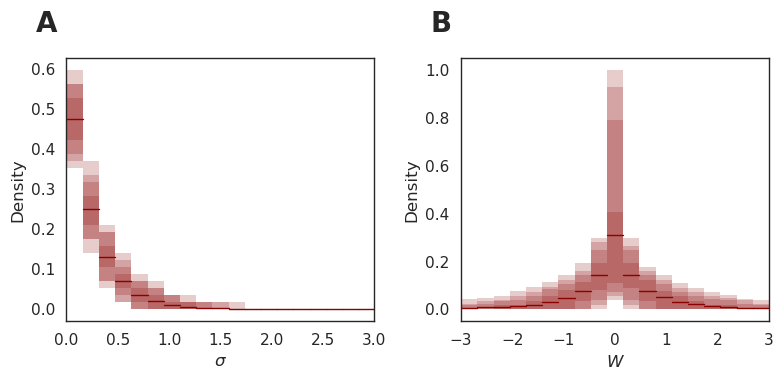

In [15]:
sns.set_context('paper', font_scale=1.25)
sidx, sheet = pd.factorize(heterogeneity_sheet['sheet'])

fig, ax = plt.subplots(1,2, figsize=(8,4))


plt.sca(ax[0])


plot_prior_ppd( hetPrior.prior['sigmas'].values.reshape(1000, -1), np.linspace(0, 3, 20), ax[0])
ax[0].set_xlim(0, 3 )
ax[0].set_xlabel(r'$\sigma$')
ax[0].set_ylabel('Density')


plot_prior_ppd( hetPrior.prior['W'].values.reshape(1000, -1), np.linspace(-3, 3, 20), ax[1])
ax[1].set_xlim(-3, 3 )
ax[1].set_xlabel(r'$W$')
ax[1].set_ylabel('Density')
#label A, B, C
from src.figures import label_subfigs
label_subfigs(ax)
plt.tight_layout()
plt.savefig('output/figures/MLHetModelPrior.png', dpi=300)

#### Step Eight: Configure Algorithm
This is a dead simple model, we'll use default sampling parameters.  

#### Step Nine: Fit simulated ensemble 
Just to make sure everything is doing what we expected, we'll fit our model to some simulated data and check that we can recover parameters. 

In [16]:
from src.util import check_diagnostics

if fit_ensemble:

    rank_dicts = []
    for j in range(30):
        prior_choice = np.random.choice(1000)

        sim_d = hetPrior.prior_predictive['Xhat'][0, prior_choice].values.ravel()
        with HetModel:
            pm.set_data({'d': sim_d})
            sim_trace = pm.sample(1000, tune=1000, return_inferencedata=True,cores=4)
            passsed = check_diagnostics(sim_trace)
            known_sigma = {'W': hetPrior.prior['tau'][0, prior_choice],
                            'sigmas': 16}
            for param in ['W', 'sigmas']:
                posterior_simmed = sim_trace.posterior[param]
                prior_value = hetPrior.prior[param][0,prior_choice, :]
                #Get the rank of prior value for each posterior simulated value
                ranks = np.array([np.sum(np.array(prior_value[idx]).ravel()> np.array(posterior_simmed[0:,:, idx]).ravel()) for idx in range(prior_value.shape[0])])
                contraction = np.array(np.std(posterior_simmed, axis=(0,1))**2 / known_sigma[param]**2)
                z_score = (prior_value - np.mean(posterior_simmed, axis=(0,1))) / np.std(posterior_simmed, axis=(0,1))
                rank_dicts.append({'prior': np.repeat(prior_choice, ranks.size), 
                                'contraction':contraction,
                                'z_score': z_score,  
                                'passed': np.repeat(passsed['success'], ranks.size),
                                'param': np.repeat(param, ranks.size),
                                'rank': ranks})
    rank_df = pd.concat([pd.DataFrame(item) for item in rank_dicts])
    rank_df.head()


#### Step Ten: Algorithmic Calibration
Let's check that our diagnostics are ubiquitously meeting criteria. The mean of our "passed" column should be 1.0, indicating that all simulated runs passed all algorthmic calibration criteria. 


In [17]:
if fit_ensemble:
    print(rank_df['passed'].mean())

#### Step Eleven: Inferential Calibration
We're going to check some [standard plots](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html), to verify that our "true" prior values are uniformly distributed in the posterior (A, C) and that the contraction is high and there are no unexpectedly extreme z-scores. This provides assurances that our model is well identified, and not substantially under/over-fit and that our prior model is not overly restrictive or problematic in some other way.  

In [18]:
#2x gridspec
from src.figures import rank_plot, eye_test 


if fit_ensemble:

    sns.set_context('paper', font_scale=1.25)   
    fig, ax = plt.subplots(2,2, figsize=(8,8))




    temp = rank_df[rank_df['param'] == 'W']
    rank_plot(temp, ax[0,0])
    plt.title(r'$W$')


    plt.sca(ax[0,1])
    eye_test(temp, ax[0,1])
    plt.xlim(0,1)
    plt.title(r'$W$')


    temp = rank_df[rank_df['param'] == 'sigmas']
    rank_plot(temp, ax[1,0])
    plt.title(r'$\sigma$')

    plt.sca(ax[1,1])
    eye_test(temp, ax[1,1])
    plt.title(r'$\sigma$')


    from src.figures import label_subfigs
    label_subfigs(ax)
    plt.tight_layout()
    plt.savefig('output/figures/MLHetEyeChart.png', dpi=300)

#### Step Twelve: Fit the observation 
We will fit the identifie dmodel to our data using default parameters. 

In [19]:
with HetModel:
    pm.set_data({'d': heterogeneity_sheet['d_obs']})
    idata_het = pm.sample(1000, tune=1000, return_inferencedata=True)
    idata_het.extend(pm.sample_posterior_predictive(idata_het))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, W, sigmas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Sampling: [Xhat]


Output()

#### Step Thirteen: Diagnose Posterior fits
Let's check our diagnostics and make sure everything went well 

In [20]:
from src.util import check_diagnostics
check_diagnostics(idata_het)

/home/joseph/anaconda3/envs/rep_survey/lib/python3.12/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu', 'alpha', 'B_raw'] have not been found and will be ignored
  warnings.warn(
/home/joseph/anaconda3/envs/rep_survey/lib/python3.12/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu', 'alpha', 'B_raw'] have not been found and will be ignored
  warnings.warn(
/home/joseph/anaconda3/envs/rep_survey/lib/python3.12/site-packages/arviz/utils.py:142: UserWarning: Items starting with ~: ['mu', 'alpha', 'B_raw'] have not been found and will be ignored
  warnings.warn(


Total divergences:  0
Max Rhat:  1.01
Min effective sample size(bulk):  2478.0
Min effective sample size(tail):  1614.0
Min BFMI:  0.9650021817866247
Good diagnostics, continue


{'Total divergences': array(0),
 'Max Rhat': 1.01,
 'Min effective sample size(bulk)': 2478.0,
 'Min effective sample size(tail)': 1614.0,
 'Min BFMI': 0.9650021817866247,
 'success': True}

#### Step Fourteen: Posterior Retrodictive Checks

In [21]:
post_pred = np.asarray(idata_het.posterior_predictive['Xhat'])
post_pred = post_pred.reshape(4000, 1994)
z_post_pred = post_pred / np.sqrt(4/np.array(heterogeneity_sheet['N']))
sig_pred = np.abs(z_post_pred) > stats.norm.ppf(.975)

In [22]:
def binom_test_apply(K, N):
    
    out = np.zeros(K.shape)
    for i in range(K.shape[0]):
        out[i] = stats.binomtest(K[i], N[i], p=.05).pvalue
    return out 

sheet_idx, sheet = pd.factorize(heterogeneity_sheet['sheet'])
sheet_idx

# Step 3: Group and sum along indices

J = 4000
grouped_result = np.zeros((J, np.max(sheet_idx) + 1))
sorted_binom_p = np.zeros((J, np.max(sheet_idx) + 1))
sorted_binom_prob = np.zeros((J, np.max(sheet_idx) + 1))

index_counts = np.bincount(sheet_idx, minlength=np.max(sheet_idx) + 1)
for i in tqdm(range(J)):
    grouped_result[i, :] = np.bincount(sheet_idx, weights=sig_pred[i, :], 
                                       minlength=np.max(sheet_idx) + 1)
    K = np.bincount(sheet_idx, weights=sig_pred[i, :], 
                                        minlength=np.max(sheet_idx) + 1).astype('int')

    N = index_counts
    sorted_binom_p[i, :] = np.sort(binom_test_apply(K,N))[::-1]
    sorted_binom_prob[i, :] = np.sort(K/N)


/tmp/ipykernel_2184262/2573175965.py:8: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  sheet_idx, sheet = pd.factorize(heterogeneity_sheet['sheet'])


  0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_2184262/2138526709.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_2184262/2138526709.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.arange(agg_df.shape[0]),


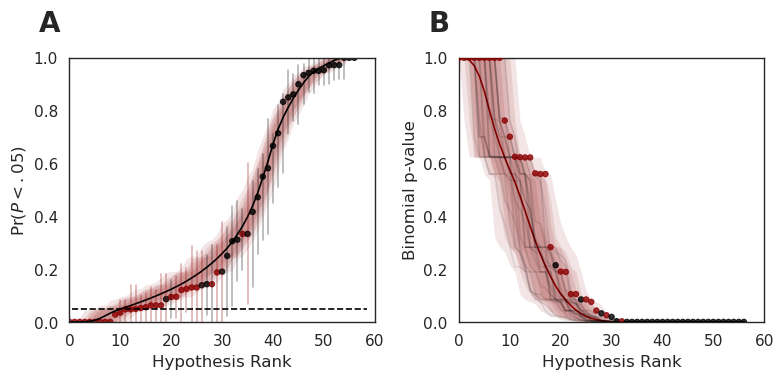

In [26]:
sns.set_style("white")
sns.set_context("paper", font_scale=1.25)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


plt.sca(ax[1])

plt.plot(sorted_binom_p.mean(axis=0),color='darkred')

for idx in range(20):
    chain = np.random.choice(sorted_binom_p.shape[0])
    plt.plot(sorted_binom_p[chain, :], color='k', alpha=.1,zorder=2)

for q in [.5, 3, 5.5, 12.5, 25]:
    low = np.percentile(sorted_binom_p, q=q/2, axis=0)
    high = np.percentile(sorted_binom_p, q=100-q/2, axis=0)
    plt.fill_between(np.arange(low.shape[0]), low, high, alpha=.1, lw=0,color='darkred',zorder=1)
agg_df = agg_df.sort(by="p",descending=True)

color = np.array(["darkred", "black"])
plt.scatter(
    np.arange(agg_df['prob'].shape[0]),
    agg_df['p'],
    c=color[agg_df['Sig']],
    cmap="Set2",
    alpha=0.8,
    s=15,
    zorder=3
)

plt.ylim(0, 1)
plt.ylabel("Binomial p-value")
plt.xlabel("Hypothesis Rank")
plt.xlim(0.5, agg_df.shape[0] + 0.5)
plt.xticks(np.linspace(0, 60, 7))

plt.sca(ax[0])

plt.plot(sorted_binom_prob.mean(axis=0),color='k')
for q in [.5, 3, 5.5, 12.5, 25]:
    low = np.percentile(sorted_binom_prob, q=q/2, axis=0)
    high = np.percentile(sorted_binom_prob, q=100-q/2, axis=0)
    plt.fill_between(np.arange(low.shape[0]), low, high, alpha=.1, lw=0,color='darkred')


agg_df = agg_df.sort('prob')
plt.scatter(np.arange(agg_df.shape[0]), 
            agg_df['prob'],
                c=color[agg_df['Sig']],
            cmap="Set2",
            alpha=0.8,
            s=15,)

confints = proportion_confint(agg_df['K'], agg_df['N'])
err = np.abs(confints-np.array(agg_df['prob']))

for iii in range(err.shape[1]):
    plt.plot([iii+1, iii + 1], [confints[0][iii], confints[1][iii]],
              c=color[agg_df['Sig']][iii], alpha=.3)
    
plt.xlabel("Hypothesis Rank")
plt.plot([0.5, agg_df.shape[0] + 1.5], [0.05, 0.05], "k--")
plt.xlim(0.5, agg_df.shape[0] + 0.5)
plt.xticks(np.linspace(0, 60, 7))
plt.ylim(0, 1)
plt.ylabel(r'$\text{Pr}(P<.05)$')
from src.figures import label_subfigs

label_subfigs(ax)
plt.tight_layout()
plt.savefig('./output/figures/PushforwardMultisite.png', dpi=300)


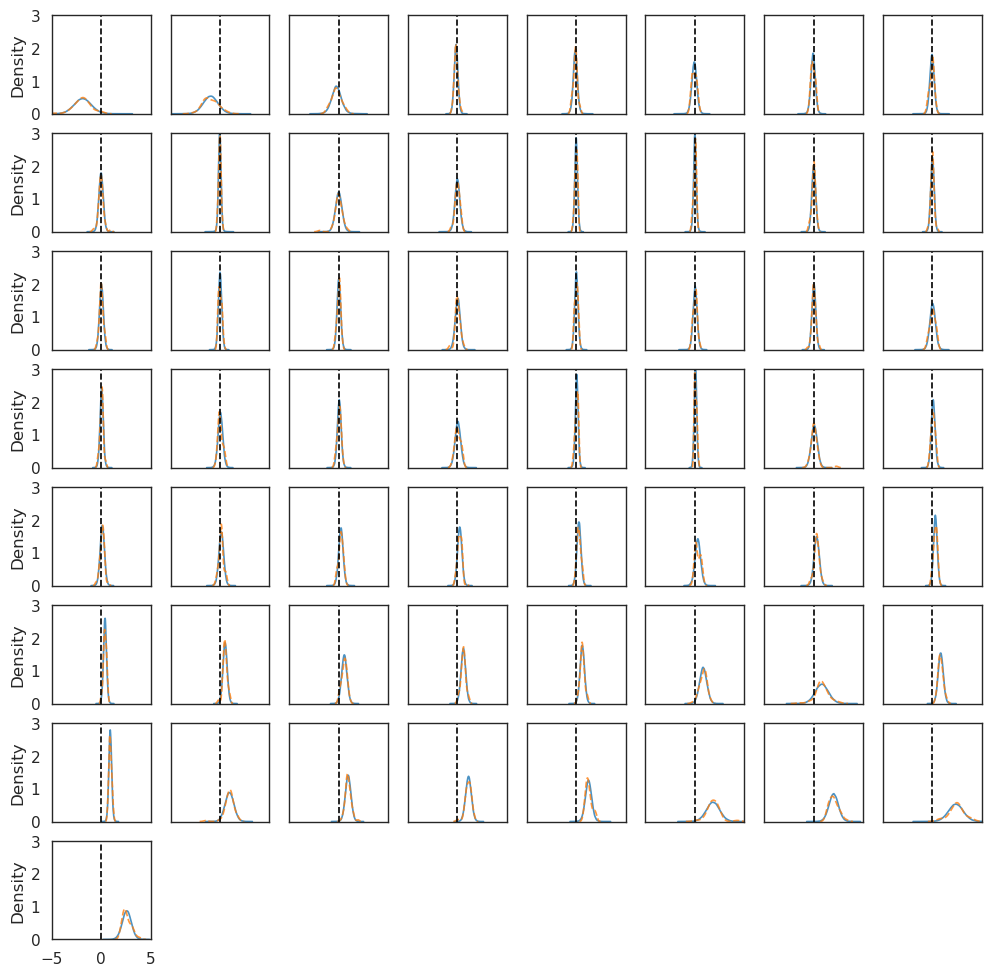

In [25]:
choice = 13
#grid large enough to hold all sheets
total_sheets = agg_df.shape[0]
columns = 8
rows = 8
fig, ax = plt.subplots(rows, columns, figsize=(12, 12))
grouped = heterogeneity_sheet.group_by('sheet').mean().sort('d_obs')
sheet_order = grouped['sheet']



for idx, sheet_name in enumerate(sheet_order):
    indices = np.where(heterogeneity_sheet['sheet']==sheet_name)[0] #Select rows for a sheet
    plt.sca(ax[idx // columns, idx % columns]) #set the axis 

    #Kde plot of the posterior for those rows followed by the observed data 
    sns.kdeplot(np.array(idata_het.posterior_predictive["Xhat"].sel({'Xhat_dim_2':indices}).values.ravel()),ls='-', alpha=.8)
    sns.kdeplot(heterogeneity_sheet.filter(pl.col('sheet')==sheet_name)['d_obs'], ls='--', alpha=.8)

    plt.xlim(-5,5)
    plt.plot([0, 0], [0, 3], 'k--')
    plt.ylim(0, 3)

#Clean up the grid 
for idx in range(rows * columns):
    plt.sca(ax[idx // columns, idx % columns])

    if idx // columns != rows - 1:
        plt.xticks([])
        plt.xlabel('')
    if idx % columns != 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel('Density')
#remove subplots that are not used
for idx in range(total_sheets, rows * columns):
    fig.delaxes(ax[idx // columns, idx % columns])
plt.savefig('output/figures/MLHetPosteriorRetrodictive.png', dpi=300)

### Additional Analyses of Many labs findings 

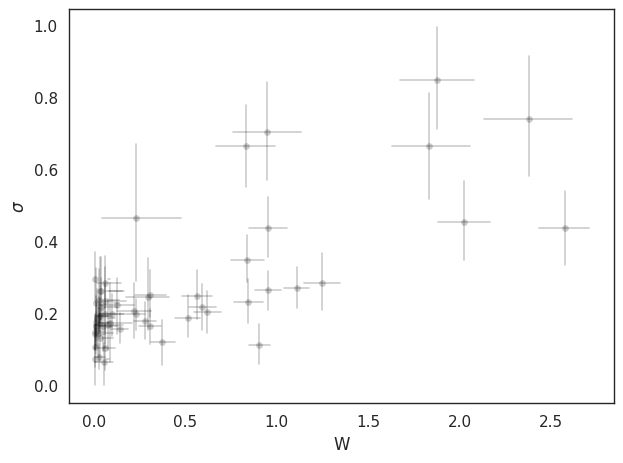

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#Here we plot the posterior estimates of the heterogeneity (sigma) and average effect size (W)
sigma_summary = az.summary(idata_het, var_names='sigmas')
w_df = az.summary(idata_het, var_names='W')
sigma_dfs = {'mean_sigma':sigma_summary['mean'],
             'sig_hdi_3%':sigma_summary['hdi_3%'],
             'sig_hdi_97%':sigma_summary['hdi_97%'],
             'hypoth':[item[7:-1] for item in sigma_summary.index]}
W_dfs = {'mean_W':w_df['mean'],
            'W_hdi_3%':w_df['hdi_3%'],
            'W_hdi_97%':w_df['hdi_97%'],
            'hypoth':[item[2:-1] for item in w_df.index]}
sigma_df = pd.DataFrame(sigma_dfs)
W_df = pd.DataFrame(W_dfs)
combined = pd.merge(sigma_df, W_df, on='hypoth')
combined.head()
plt.scatter(np.abs(combined['mean_W']), combined['mean_sigma'],alpha=.4,color='grey',lw=0)
plt.xlabel('W')
plt.ylabel(r'$\sigma$')
plt.plot([np.abs(combined['mean_W']), np.abs(combined['mean_W'])], [combined['sig_hdi_3%'], combined['sig_hdi_97%']], 'k',alpha=.2)
plt.plot( [np.abs(combined['W_hdi_3%']), np.abs(combined['W_hdi_97%'])],[combined['mean_sigma'], combined['mean_sigma']], 'k',alpha=.2)
plt.tight_layout()
plt.savefig('output/figures/MLHetSigmaW.png', dpi=300)


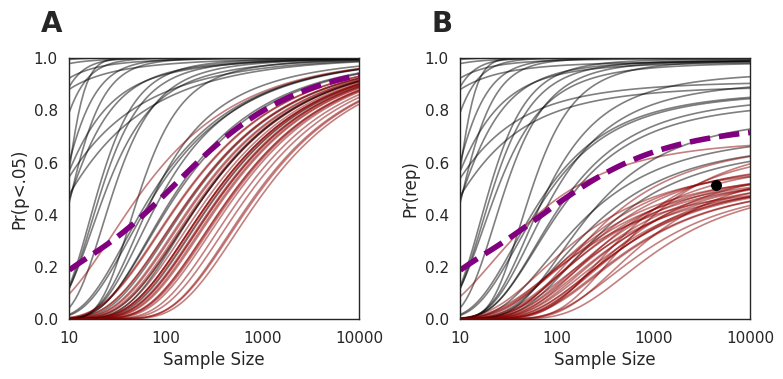

In [ ]:
idata_het.posterior['W'].mean(dim=('chain','draw'))

z_crit = norm.ppf(.975)

#2x1 gridspec
fig, ax = plt.subplots(1,2, figsize=(8,4))
plt.sca(ax[0])

probs = []
for N in np.logspace(1, 4, 100):
    d_crit = z_crit / np.sqrt(N/2)

    probs.append(norm(idata_het.posterior['W'].mean(dim=('chain','draw')), 
        np.sqrt(idata_het.posterior['sigmas'].mean(dim=('chain','draw'))**2 + 1/n)).cdf(-d_crit) + \
            (1-norm(idata_het.posterior['W'].mean(dim=('chain','draw')),
                    np.sqrt(idata_het.posterior['sigmas'].mean(dim=('chain','draw'))**2 + 1/n)).cdf(d_crit)))
prob = np.vstack(probs)

for idx in range(prob.shape[1]):
    rep = agg_df.filter(pl.col(['sheet'])==combined['hypoth'][idx])['Sig'][0]
    if rep:
        color = 'black'
    else:
        color = 'darkred'
    plt.plot(np.logspace(1, 4, 100), prob[:, idx], color=color, alpha=.5)
    
#log x axis
plt.xscale('log')
#natural x axis
plt.xticks([10, 100, 1000, 10000], ['10', '100', '1000', '10000'])
plt.xlabel('Sample Size')
plt.ylabel('Pr(p<.05)')
plt.xlim(10, 10000)
plt.ylim(0,1)


probs = []
for N in np.logspace(1, 4, 100):
    d_crit = z_crit / np.sqrt(N/2)

    negative_sig = norm(idata_het.posterior['W'].mean(dim=('chain','draw')), 
        np.sqrt(idata_het.posterior['sigmas'].mean(dim=('chain','draw'))**2 + 1/n)).cdf(-d_crit)
    positive_sig = (1-norm(idata_het.posterior['W'].mean(dim=('chain','draw')),
                   np.sqrt(idata_het.posterior['sigmas'].mean(dim=('chain','draw'))**2 + 1/n)).cdf(d_crit))
    #select the largest from the two for each item along the axis
    negative_sig[negative_sig < positive_sig] = positive_sig[negative_sig < positive_sig]
    probs.append(negative_sig)

y_mean = np.mean(prob, axis=1)
plt.plot(np.logspace(1, 4, 100), y_mean, color='purple', lw=4, ls='--') 
    
plt.sca(ax[1])
prob = np.vstack(probs)

for idx in range(prob.shape[1]):
    rep = agg_df.filter(pl.col(['sheet'])==combined['hypoth'][idx])['Sig'][0]
    if rep:
        color = 'black'
    else:
        color = 'darkred'
    plt.plot(np.logspace(1, 4, 100), prob[:, idx], color=color, alpha=.5)

y_mean = np.mean(prob, axis=1)
plt.plot(np.logspace(1, 4, 100), y_mean, color='purple', lw=4, ls='--')
#log x axis
plt.xscale('log')
#natural x axis
plt.xticks([10, 100, 1000, 10000], ['10', '100', '1000', '10000'])
plt.xlabel('Sample Size')
plt.ylabel('Pr(rep)')
plt.xlim(10, 10000)
plt.ylim(0,1)
plt.tight_layout()

meta_analytic_sig = agg_df['Sig'].mean
meta_analytic_average_n = np.median(heterogeneity_sheet.group_by('sheet').sum()['N'])
plt.scatter(meta_analytic_average_n, np.mean(probs), color='k', s=50,zorder=2)

probs = []

from src.figures import label_subfigs
label_subfigs(ax)
plt.tight_layout()
plt.savefig('output/figures/MLSigRep.png', dpi=300)